In [1]:
import os

In [7]:
sm_eov = '/mnt/storage/code/pywapor-clms/sm_300m_eov.tif'
sm_fao = '/mnt/storage/code/pywapor-clms/sm_fao/cropped_WAPOR-3.L1-RSM-D.2023-01-D1_38b24750.tif'

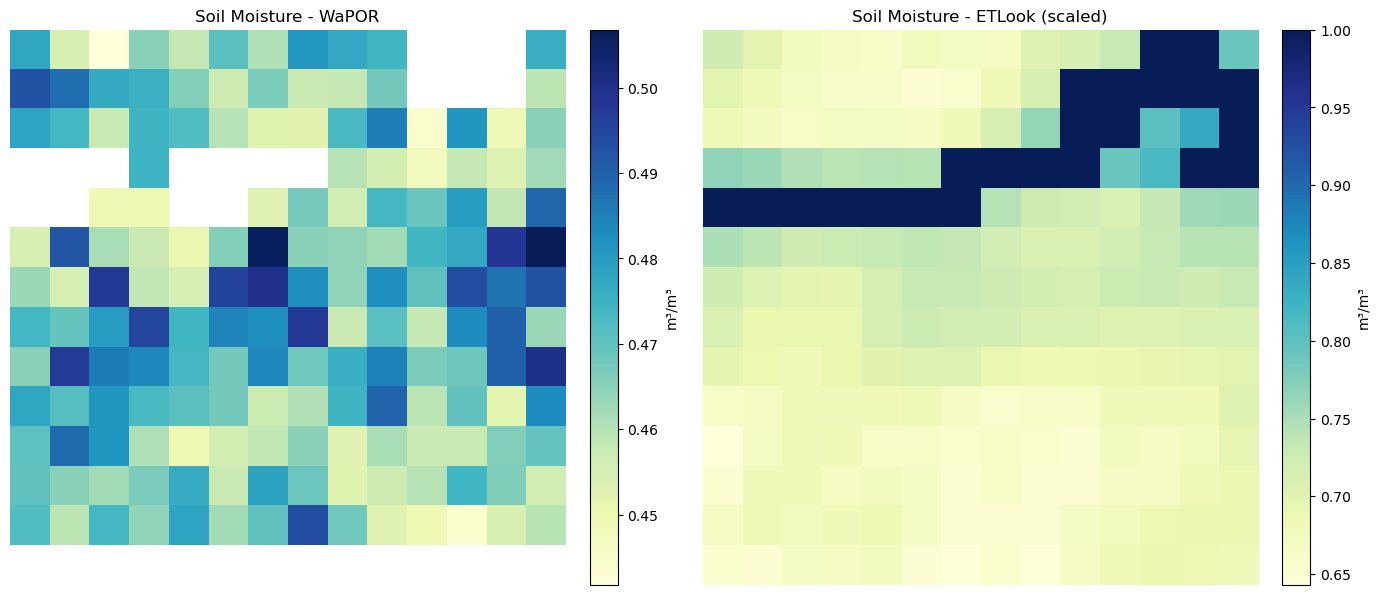

In [8]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Load the two raster files
wapor_path = sm_eov
etlook_path = sm_fao

with rasterio.open(wapor_path) as src1:
    sm1 = src1.read(1)
    profile1 = src1.profile

with rasterio.open(etlook_path) as src2:
    sm2 = src2.read(1)
    profile2 = src2.profile

# Scale sm2 as requested
sm2_scaled = sm2 * 0.001

# Mask no-data values
sm1 = np.ma.masked_where(sm1 == profile1['nodata'], sm1)
sm2_scaled = np.ma.masked_where(sm2 == profile2['nodata'], sm2_scaled)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

cmap = 'YlGnBu'
im1 = axs[0].imshow(sm1, cmap=cmap)
axs[0].set_title("Soil Moisture - WaPOR")
plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, label='m³/m³')

im2 = axs[1].imshow(sm2_scaled, cmap=cmap)
axs[1].set_title("Soil Moisture - ETLook (scaled)")
plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, label='m³/m³')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [6]:
import rioxarray as rxr

# Mở ảnh gốc 100m
da_100m = rxr.open_rasterio("/mnt/storage/code/pywapor-clms/dataset/sm/2023-01-01.tif", masked=True).squeeze()

# Mở ảnh mẫu 300m
template_300m = rxr.open_rasterio("//mnt/storage/code/pywapor-clms/sm_fao/cropped_WAPOR-3.L1-RSM-D.2023-01-D1_38b24750.tif", masked=True).squeeze()

# Đảm bảo khớp CRS
if not da_100m.rio.crs:
    da_100m = da_100m.rio.write_crs(template_300m.rio.crs)

# Resample về 300m
da_300m = da_100m.rio.reproject_match(template_300m)

# Lưu ảnh mới ra file .tif
da_300m.rio.to_raster("sm_300m_eov.tif")


masked_array(
  data=[[0.72200006, 0.69900006, 0.675     , 0.665     , 0.66200006,
         0.67300004, 0.669     , 0.67      , 0.703     , 0.71500003,
         0.731     , 1.        , 1.        , 0.791     ],
        [0.70000005, 0.68100005, 0.669     , 0.65900004, 0.65900004,
         0.65400004, 0.65800005, 0.68      , 0.712     , 1.        ,
         1.        , 1.        , 1.        , 1.        ],
        [0.68200004, 0.67200005, 0.66300005, 0.669     , 0.666     ,
         0.66400003, 0.67800003, 0.71400005, 0.763     , 1.        ,
         1.        , 0.80200005, 0.836     , 1.        ],
        [0.767     , 0.75900006, 0.74500006, 0.74      , 0.74300003,
         0.74200004, 1.        , 1.        , 1.        , 1.        ,
         0.79200006, 0.814     , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 0.74300003, 0.725     , 0.71900004,
         0.711     , 0.73300004, 0.75600004, 0.75900006],
      

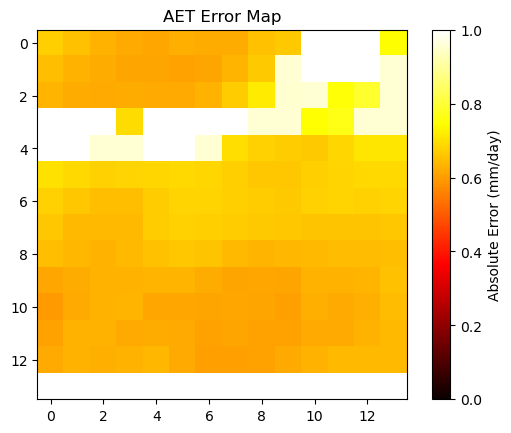

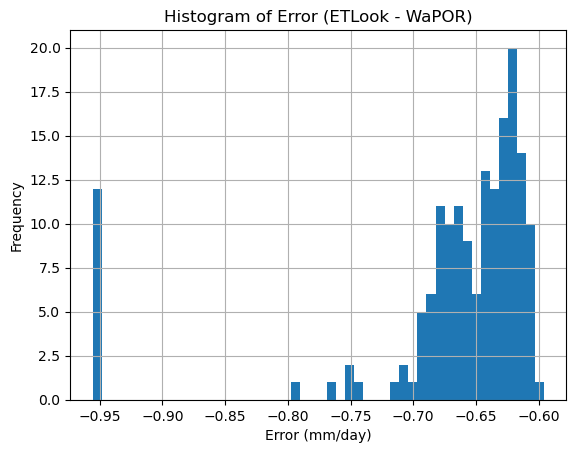

MSE: 0.4573
RMSE: 0.6762


In [21]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

def compute_mse_rmse(path1: str, path2: str):
    # Mở 2 ảnh và squeeze để loại chiều dư (nếu có band)
    img1 = rioxarray.open_rasterio(path1, masked=True).squeeze() * 0.1
    img2 = rioxarray.open_rasterio(path2, masked=True).squeeze() * 0.001

    # Đảm bảo cùng shape
    if img1.shape != img2.shape:
        raise ValueError(f"Different shapes: {img1.shape} vs {img2.shape}")
    # Convert về numpy array
    arr1 = img1.values
    arr2 = img2.values
    # Mặt nạ hợp lệ: cả hai ảnh đều không bị mask
    mask = (~np.isnan(arr1)) & (~np.isnan(arr2))

    error_map = np.full_like(arr1, np.nan)
    error_map[mask] = np.abs(arr1[mask] - arr2[mask])

    plt.imshow(error_map, cmap="hot", vmin=0, vmax=1)
    plt.colorbar(label="Absolute Error (mm/day)")
    plt.title("AET Error Map")
    plt.show()
    # Tính MSE và RMSE
    mse = np.mean((arr1[mask] - arr2[mask]) ** 2)
    rmse = np.sqrt(mse)

    plt.hist(arr1[mask] - arr2[mask], bins=50)
    plt.title("Histogram of Error (ETLook - WaPOR)")
    plt.xlabel("Error (mm/day)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    return mse, rmse

# 🔧 Ví dụ sử dụng:
path_img1 = "/mnt/storage/code/pywapor-clms/sm_fao/cropped_WAPOR-3.L1-RSM-D.2023-01-D1_38b24750.tif"
path_img2 = "/mnt/storage/code/pywapor-clms/sm_300m_eov.tif"

mse, rmse = compute_mse_rmse(path_img2, path_img1)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
